In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/home/PangeAI/Documents/work/scalexa/pangeaai/optimize-cosine'

In [2]:
import json
import math
import warnings
from itertools import product
from multiprocessing import shared_memory
from multiprocessing.pool import ThreadPool
from pathlib import Path
from time import perf_counter
from typing import Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from matchms import Spectrum
from matchms.filtering import (add_losses, normalize_intensities,
                               reduce_to_number_of_peaks,
                               require_minimum_number_of_peaks, select_by_mz,
                               select_by_relative_intensity)
from matchms.similarity import CosineGreedy as OriginalCosineGreedy
from matchms.similarity.BaseSimilarity import BaseSimilarity
from matchms.similarity.spectrum_similarity_functions import (
    collect_peak_pairs, score_best_matches)
from matchms.typing import SpectrumType
from numba import cuda
from tqdm import tqdm

assert cuda.is_available()

In [3]:
def get_ref_spectra_from_df(spectra_df, 
                            limit=None,
                            spectrum_processor: callable = None,
                            ) -> pd.DataFrame:
    """
    This function will take a dataframe with spectra and return a list of matchms spectra.
    Since all rows are independent, this function does this preprocessing in parallel (CPU).
    """
    # for index, row in spectra_df.iterrows():
    def fn(index, row):
        pbid = row["pbid"]
        precursor_mz = row["precursor_mz"]
        smiles = row["pb_smiles"]
        inchikey = row["pb_inchikey"]
        mz_array = np.array(json.loads(row["peaks_mz"]))
        intensity_array = np.array(json.loads(row["peaks_intensities"]))
        sp = Spectrum(
            mz=mz_array,
            intensities=intensity_array,
            metadata={
                "id": pbid,
                "precursor_mz": precursor_mz,
                "smiles": smiles,
                "inchikey": inchikey,
            },
        )
        if spectrum_processor is not None:
            sp = spectrum_processor(sp)
        return sp

    if limit is not None:
        spectra_df = spectra_df.head(limit)
    spectra = Parallel(-2)(
        delayed(fn)(index, row)
        for index, row in tqdm(spectra_df.iterrows(), total=len(spectra_df))
    )
    spectra = [s for s in spectra if s is not None]
    return spectra


In [4]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

# Use first sample_size * sample_size pairs for comparison only
sample_size = 64

# number of points on x-axis in plots
x_num = 20

# number of repeats for each experiment to get confidence interval

# MAX NUMBER OF PEAKS 
max_peaks = 1024

# Data path
reference_csv_file = Path("data/input/test_set_cosine.csv")
query_csv_file = Path("data/input/test_set_cosine.csv")

In [5]:
from matchms import calculate_scores
from tqdm import tqdm
from matchms.filtering import normalize_intensities, select_by_mz, select_by_relative_intensity, reduce_to_number_of_peaks, \
    require_minimum_number_of_peaks

def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
    # spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    # spectrum = normalize_intensities(spectrum)
    # spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    # spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=max_peaks) # This is the only one necessary.
    # spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum

ref_spectra_df_path = Path(reference_csv_file)
ref_spectra_df = pd.read_csv(ref_spectra_df_path)

references_all = get_ref_spectra_from_df(ref_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=sample_size * 4,)

query_spectra_df_path = Path(query_csv_file)
query_spectra_df = pd.read_csv(query_spectra_df_path)
queries_all = get_ref_spectra_from_df(query_spectra_df, 
                                spectrum_processor=process_spectrum,
                                limit=sample_size * 4,)

100%|██████████| 256/256 [00:00<00:00, 2138.24it/s]


In [9]:
import random
import seaborn as sns
from matchms.similarity import CosineGreedy

class StableCosineGreedy(CosineGreedy):
    """Stable implementation of original cosine greedy"""
    def __init__(self, tolerance: float = 0.1, mz_power: float = 0, intensity_power: float = 1):
        super().__init__(tolerance, mz_power, intensity_power)
        
    def pair(self, reference: SpectrumType, query: SpectrumType) -> Tuple[float, int]:
        """Calculate cosine score between two spectra.

        Parameters
        ----------
        reference
            Single reference spectrum.
        query
            Single query spectrum.

        Returns
        -------
        Score
            Tuple with cosine score and number of matched peaks.
        """
        def get_matching_pairs():
            """Get pairs of peaks that match within the given tolerance."""
            matching_pairs = collect_peak_pairs(spec1, spec2, self.tolerance,
                                                shift=0.0, mz_power=self.mz_power,
                                                intensity_power=self.intensity_power)
            if matching_pairs is None:
                return None
            # This is the only argument that we change `kind='mergesort'`
            matching_pairs = matching_pairs[np.argsort(matching_pairs[:, 2],kind='mergesort')[::-1], :]
            return matching_pairs

        spec1 = reference.peaks.to_numpy
        spec2 = query.peaks.to_numpy
        matching_pairs = get_matching_pairs()
        if matching_pairs is None:
            return np.asarray((float(0), 0), dtype=self.score_datatype)
        score = score_best_matches(matching_pairs, spec1, spec2,
                                self.mz_power, self.intensity_power)
        return np.asarray(score, dtype=self.score_datatype)

n_repeats = 16
data = []
for _ in range(n_repeats):
    tolerances = [.01] + np.linspace(.01, .3, x_num).tolist() # We need to omit time for jit compilation

    pairs_per_sec_mergesort = []
    for tolerance in tqdm(tolerances):
        similarity_measure = StableCosineGreedy(tolerance=tolerance, 
                                        mz_power=mz_power, 
                                        intensity_power=int_power)
        references = random.sample(references_all, sample_size)
        queries = random.sample(queries_all, sample_size)
        duration = -perf_counter()
        scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
        duration += perf_counter()
        
        n_pairs = len(references) * len(queries)
        pairs_per_sec = n_pairs / duration
        
        pairs_per_sec_mergesort.append(pairs_per_sec)
        

    pairs_per_sec_quicksort = []
    for tolerance in tqdm(tolerances):
        similarity_measure = CosineGreedy(tolerance=tolerance, 
                                        mz_power=mz_power, 
                                        intensity_power=int_power)

        references = random.sample(references_all, sample_size)
        queries = random.sample(queries_all, sample_size)
        duration = -perf_counter()
        scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
        duration += perf_counter()
        
        n_pairs = len(references) * len(queries)
        pairs_per_sec = n_pairs / duration
        
        pairs_per_sec_quicksort.append(pairs_per_sec)
        
    # We remove time used for compilation and warmup.
    tolerances = tolerances[1:]
    pairs_per_sec_quicksort = pairs_per_sec_quicksort[1:]
    pairs_per_sec_mergesort = pairs_per_sec_mergesort[1:]
    data.append([tolerances, pairs_per_sec_quicksort, pairs_per_sec_mergesort])

100%|██████████| 21/21 [00:04<00:00,  4.46it/s]


(0.0, 24907.74278193899)

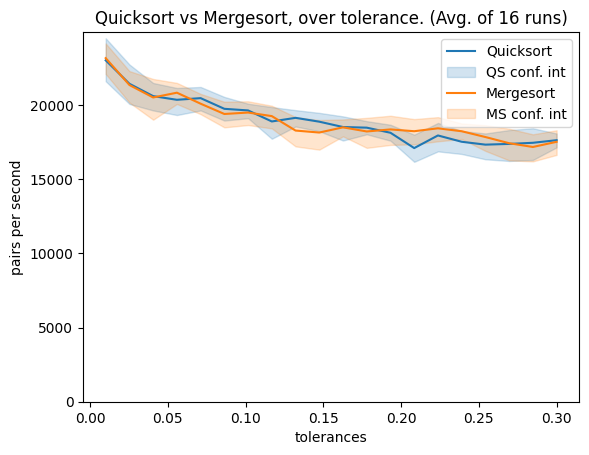

In [20]:
d = pd.DataFrame(np.concatenate(data,axis=-1).T, columns=['tolerances','quicksort','mergesort'])
ax = sns.lineplot(d, x='tolerances', y='quicksort')
sns.lineplot(d, x='tolerances', y='mergesort')
ax.legend(['Quicksort', 'QS conf. int', "Mergesort", 'MS conf. int',])
plt.ylabel('pairs per second')
plt.title("Quicksort vs Mergesort, over tolerance. (Avg. of 16 runs)")
plt.ylim(0, None)

In [21]:
from functools import lru_cache

@lru_cache
def get_references_and_queries(max_peaks):
    def process_spectrum(spectrum: np.ndarray) -> np.ndarray:
        # spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
        # spectrum = normalize_intensities(spectrum)
        # spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
        # spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
        spectrum = reduce_to_number_of_peaks(spectrum, n_max=max_peaks)
        # spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
        return spectrum

    ref_spectra_df_path = Path(reference_csv_file)
    ref_spectra_df = pd.read_csv(ref_spectra_df_path)
    references = get_ref_spectra_from_df(ref_spectra_df, 
                                        spectrum_processor=process_spectrum,
                                        limit=sample_size * 4,)

    query_spectra_df_path = Path(query_csv_file)
    query_spectra_df = pd.read_csv(query_spectra_df_path)
    queries = get_ref_spectra_from_df(query_spectra_df, 
                                    spectrum_processor=process_spectrum,
                                    limit=sample_size * 4,)
    return references, queries

In [60]:
# Tolerance back to default
tolerance = .1
n_repeats = 5
data = []
for _ in range(n_repeats):
    # Same, discard first iteration because it's spent on compiling
    all_max_peaks = [64] + np.linspace(64, 1024 * 2, x_num, dtype='int32').tolist()

    pairs_per_sec_mergesort = []
    for max_peaks in tqdm(all_max_peaks):
        references, queries = get_references_and_queries(max_peaks=max_peaks)
        similarity_measure = StableCosineGreedy(tolerance=tolerance, 
                                        mz_power=mz_power, 
                                        intensity_power=int_power)
        duration = -perf_counter()
        scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
        duration += perf_counter()
        
        n_pairs = len(references) * len(queries)
        pairs_per_sec = (n_pairs / duration)
        pairs_per_sec_mergesort.append(pairs_per_sec)
        
    pairs_per_sec_quicksort = []
    for max_peaks in tqdm(all_max_peaks):
        references, queries = get_references_and_queries(max_peaks=max_peaks)
        
        similarity_measure = CosineGreedy(tolerance=tolerance, 
                                        mz_power=mz_power, 
                                        intensity_power=int_power)

        duration = -perf_counter()
        scores = calculate_scores(references, queries, similarity_measure, is_symmetric=False)
        duration += perf_counter()
        
        n_pairs = len(references) * len(queries)
        pairs_per_sec = (n_pairs / duration)
        
        pairs_per_sec_quicksort.append(pairs_per_sec)

    all_max_peaks = all_max_peaks[1:]
    pairs_per_sec_quicksort = pairs_per_sec_quicksort[1:]
    pairs_per_sec_mergesort = pairs_per_sec_mergesort[1:]
    data.append([all_max_peaks, pairs_per_sec_quicksort, pairs_per_sec_mergesort])

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|▍         | 1/21 [00:00<00:03,  5.19it/s]


KeyboardInterrupt: 

<Axes: xlabel='max_peaks', ylabel='quicksort'>

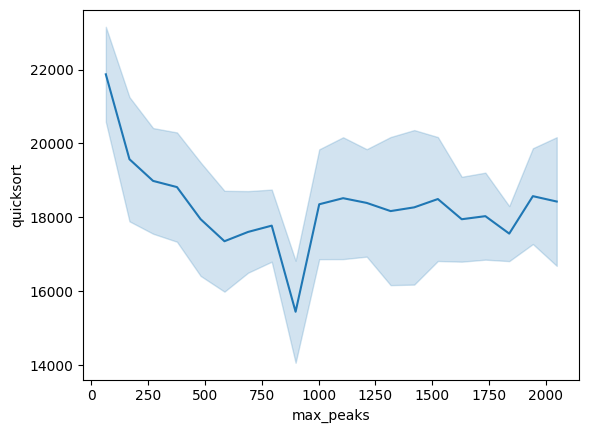

In [59]:
d = pd.DataFrame(np.concatenate(data,axis=-1).T, columns=['max_peaks','quicksort','mergesort'])
import seaborn as sns
sns.lineplot(d, x='max_peaks', y='quicksort')

(0.0, 26322.77166088773)

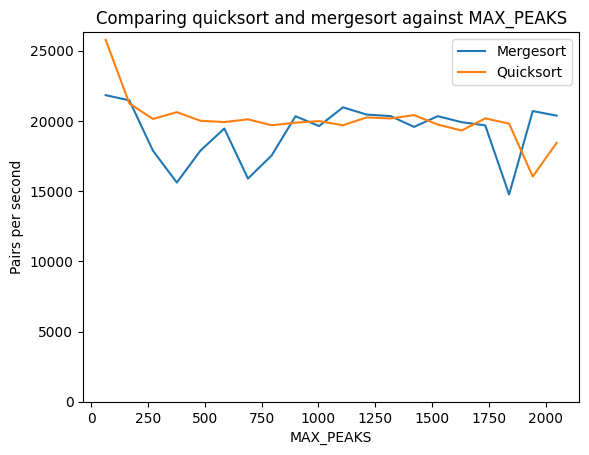

In [23]:
plt.plot(all_max_peaks, pairs_per_sec_mergesort, all_max_peaks, pairs_per_sec_quicksort)
plt.xlabel('MAX_PEAKS')
plt.ylabel('Pairs per second')
plt.legend(["Mergesort",'Quicksort'])
plt.title("Comparing quicksort and mergesort against MAX_PEAKS")
plt.legend(["Mergesort",'Quicksort'])
plt.ylim(0, None)